In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, coint, grangercausalitytests, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
def nice_date_axis(ax, max_ticks=10):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    for lab in ax.get_xticklabels():
        lab.set_rotation(30)
        lab.set_ha('right')

def format_bps(x, pos):
    # for yields (in percent), show as bps on right axis if needed
    return f"{x*100:.0f} bps"  # input assumed in decimals (0.05 -> 5%)

In [21]:
df = pd.read_csv(r"C:\Users\ASUS\Documents\-em-bond-macro-analysis\data\Cleaned\panel_monthly_2010_2024_copy.csv", parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.sort_index()
india = df[df['country'] == 'India']

In [22]:
df['log_brent'] = np.log(df['brent'])
df['log_usd_index'] = np.log(df['usd_index'])

In [23]:
# simple cleaning: report missing
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 country                    0
yield_10y                111
CPI_annual_pct             0
GDP_growth_annual_pct      0
External_debt_usd         37
usd_index                  3
brent                      3
log_brent                  3
log_usd_index              3
dtype: int64


In [28]:
# 1) Individual time series with rolling mean + volatility
def plot_series_with_roll(series, label=None, roll=12, min_periods=None, to_bps=False):
    import matplotlib.pyplot as plt
    if min_periods is None:
        min_periods = roll  # stricter default
    s = series.dropna()
    if to_bps:
        s = s * 100  # percent -> bps (if series was in %)
    roll_obj = s.rolling(roll, min_periods=min_periods)
    rm = roll_obj.mean()
    rs = roll_obj.std()

    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(s.index, s, label=label or s.name, alpha=0.7)
    ax.plot(rm.index, rm, linestyle='--', label=f'{roll}-mo MA')
    ax.fill_between(rm.index, rm - rs, rm + rs, alpha=0.12)
    ax.set_title(f"{label or s.name} — {s.index.min().date()} to {s.index.max().date()}")
    ax.set_ylabel(('bps' if to_bps else 'units'))
    nice_date_axis(ax)
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()

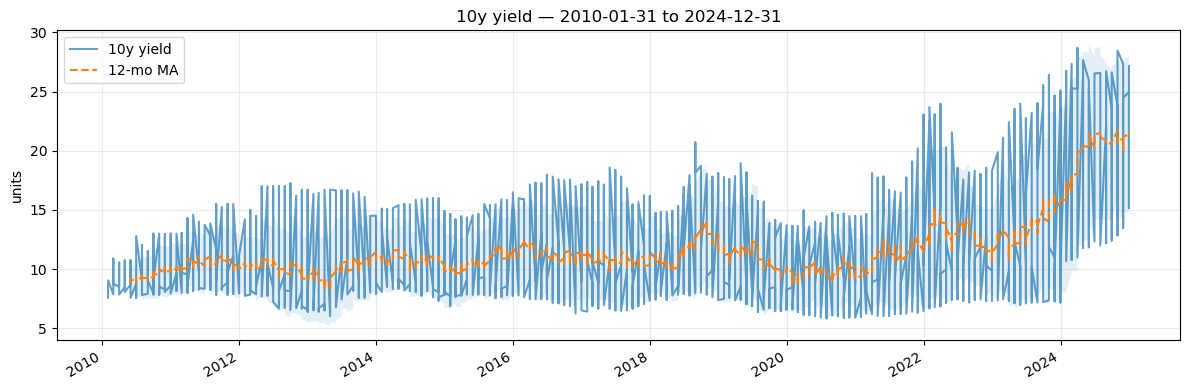

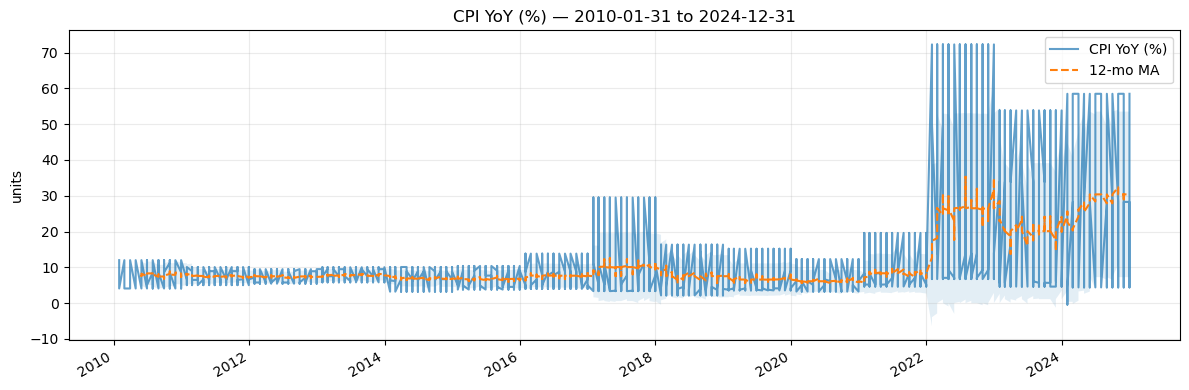

In [29]:
# example
plot_series_with_roll(df['yield_10y'], label='10y yield', roll=12)
plot_series_with_roll(df['CPI_annual_pct'], label='CPI YoY (%)', roll=12)

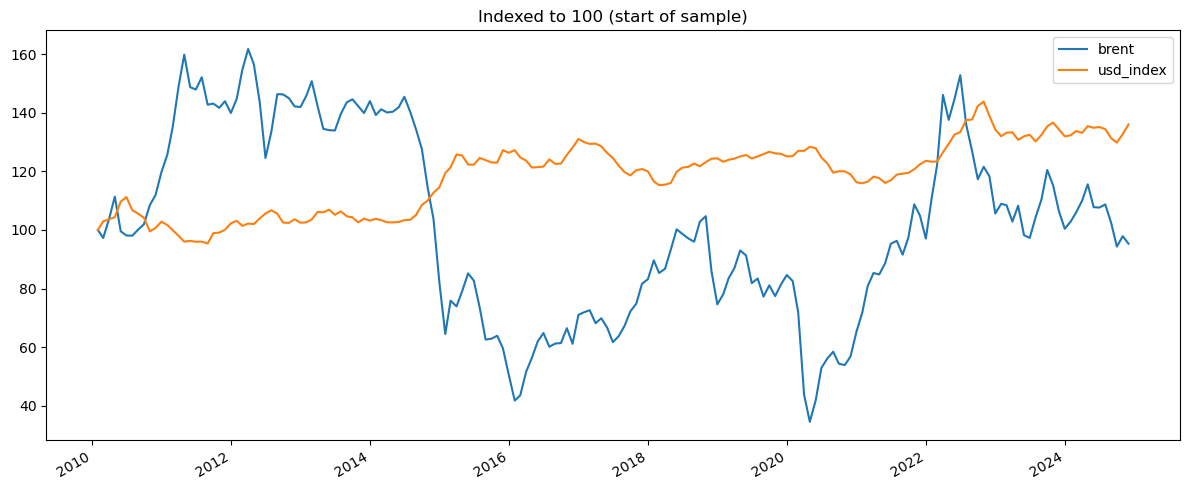

In [30]:
# 2) Index all series to 100 at start (visual comparison)

def index_to_100(series):
    return 100 * series / series.iloc[0]

plt.figure(figsize=(12,5))
for col in ['yield10', 'brent', 'usd_index', 'cpi']:  # pick relevant
    if col in df:
        plt.plot(index_to_100(df[col]), label=col)
plt.title('Indexed to 100 (start of sample)')
plt.legend()
ax = plt.gca()
nice_date_axis(ax)
plt.tight_layout()
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 983 and the array at index 1 has size 872

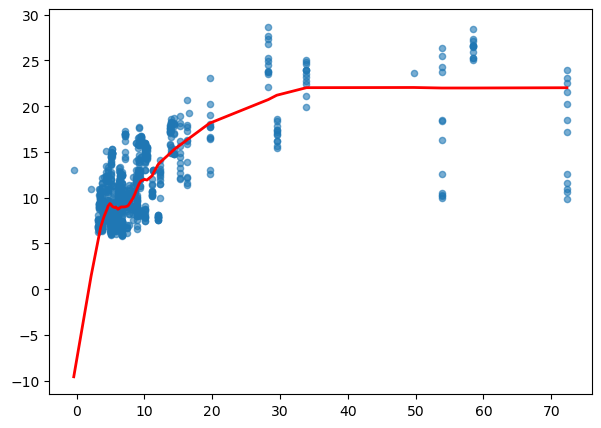

In [32]:
# 3) Scatter + LOWESS with annotated correlation

import statsmodels.nonparametric.smoothers_lowess as lowess

def scatter_with_lowess(x, y, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(x, y, s=20, alpha=0.6)
    # lowess
    z = lowess.lowess(y.fillna(0), x.fillna(0), frac=0.3)
    ax.plot(z[:,0], z[:,1], color='red', lw=2)
    r = np.corrcoef(x.dropna(), y.dropna())[0,1]
    ax.set_xlabel(xlabel or x.name)
    ax.set_ylabel(ylabel or y.name)
    ax.set_title(f"{y.name} vs {x.name} — Pearson r={r:.2f}")
    plt.tight_layout()
    plt.show()

scatter_with_lowess(df['CPI_annual_pct'], df['yield_10y'], xlabel='CPI YoY (%)', ylabel='10y yield (%)')

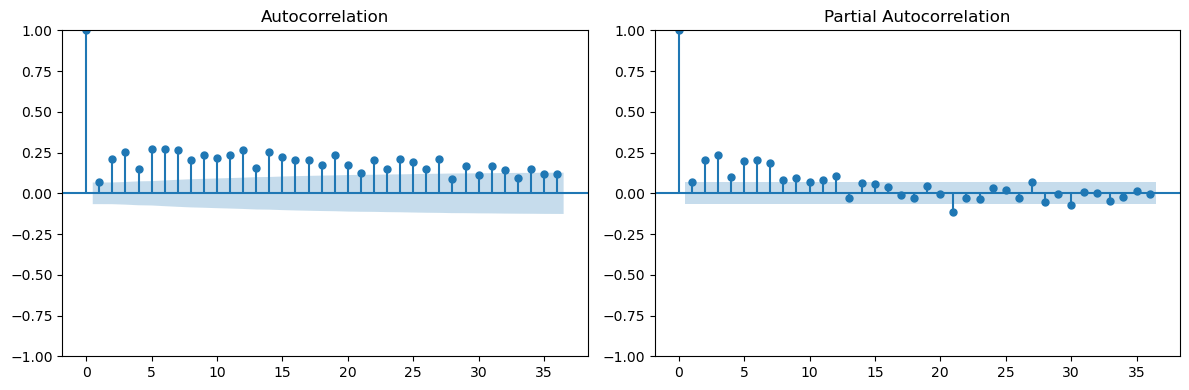

ValueError: operands could not be broadcast together with shapes (872,) (983,) 

In [35]:
# 4) ACF / PACF

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
plot_acf(df['yield_10y'].dropna(), lags=36, ax=ax)
ax2 = fig.add_subplot(122)
plot_pacf(df['yield_10y'].dropna(), lags=36, ax=ax2, method='ywm')
plt.tight_layout()
plt.show()


# 5) Cross-correlation function (lead/lag)

def plot_ccf_xy(x, y, maxlags=24):
    # statsmodels ccf gives positive lags (x leading y)
    n = len(x.dropna().index.intersection(y.dropna().index))
    c_pos = ccf(x.fillna(0), y.fillna(0))[:maxlags+1]
    c_neg = ccf(y.fillna(0), x.fillna(0))[:maxlags+1][1:][::-1]  # negative lags
    c = np.concatenate([c_neg, c_pos])
    lags = np.arange(-maxlags, maxlags+1)
    conf = 2/np.sqrt(n)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(lags, c, width=0.6)
    ax.plot(lags, [conf]*len(lags), 'r--', linewidth=1)
    ax.plot(lags, [-conf]*len(lags), 'r--', linewidth=1)
    ax.set_title(f'Cross-corr: {x.name} (lead) vs {y.name} (lag)')
    ax.set_xlabel('lag (months). Positive => x leads y')
    nice_date_axis(ax)
    plt.tight_layout()
    plt.show()

plot_ccf_xy(df['CPI_annual_pct'].dropna(), df['yield_10y'].dropna(), maxlags=24)
